# Measuring hydrostatic masses for SDSSRM-XCS galaxy clusters

In this notebook we perform new measurements of hydrostatic mass for a subset of the SDSSRM-XCS volume-limited, temperature error limited, galaxy cluster sample. We also aim to use the masses to construct mass observable relations between mass and various X-ray quantities, as well as mass and the optical quantity richness. 

In [7]:
import pandas as pd
import numpy as np
from astropy.units import Quantity, UnitConversionError
from astropy.cosmology import LambdaCDM, WMAP9
import matplotlib.pyplot as plt
from typing import Union, List
from shutil import rmtree
import os
from tqdm import tqdm

# This adds the directory above to the path, allowing me to import the common functions that I've written in
#  common.py - this just saves me repeating boring code and makes sure its all consistent
import sys
sys.path.insert(0, '..')
from common import xcs3p_colour, xcs_cosmo, direct_comparison_plot, find_lims, fit_comp

import xga
# This just sets the number of cores this analysis is allowed to use
xga.NUM_CORES = 90
# This is a bodge that will only work because xga_output in notebooks has already been defined, XGA
#  will be made to handle this more gracefully at some point
temp_dir = xga.OUTPUT
actual_dir = temp_dir.split('notebooks/')[0]+'notebooks/xga_output/'
xga.OUTPUT = actual_dir
xga.utils.OUTPUT = actual_dir
# As currently XGA will setup an xga_output directory in our current directory, I remove it to keep it all clean
if os.path.exists('xga_output'):
    rmtree('xga_output')
from xga.samples import ClusterSample
from xga.sourcetools.mass import inv_abel_dens_onion_temp

## Reading in sample file and Declaring XGA ClusterSample

Reading in the sample csv file, containing initial XAPA positions, redshifts, initial XCS3P $R_{500}$ estimates, and richnesses. This is used to define the XGA ClusterSample, which in turn is what hydrostatic mass measurements are run on.

In [2]:
xcs3p = pd.read_csv("../../sample_files/xcs3p_sdssrm_vol_lim_temperr_25%_clusters.csv")
xcs3p_r2500 = pd.read_csv("../../sample_files/xcs3p_sdssrm_r2500_props_nonvol_lim_temperr_100%_clusters.csv")

In [3]:
# Reading out the relevant values into arrays just for ease of passing into the ClusterSample object
ra = xcs3p['xapa_ra'].values
dec = xcs3p['xapa_dec'].values
z = xcs3p['z'].values
# Not using the IAU names in XCS_NAME column, its easier for me to use the name based on redMaPPer ID
n = xcs3p['name'].values
# In arcminutes, ClusterSample declaration will convert to kpc using the provided cosmology
r500 = Quantity(xcs3p['r500'].values, 'arcmin')
# Not likely to use richness in this notebook, but I'm putting it in the sample object anyway
r = xcs3p['richness'].values
r_err = xcs3p['richness_err'].values

# Declaring the actual ClusterSample instance for the XCS sample
xcs_srcs = ClusterSample(ra, dec, z, n, r500=r500, richness=r, richness_err=r_err, cosmology=xcs_cosmo, 
                         load_fits=True, use_peak=True, clean_obs=True, clean_obs_reg='r500', 
                         clean_obs_threshold=0.7)

Declaring BaseSource Sample:   2%|▉                                           | 3/150 [00:07<05:11,  2.12s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning: SDSSXCS-1018 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/notebooks/xga_output/0403760701/0403760701_mos2_SDSSXCS-1018_ra4.40770188868068_dec-0.8809301192123772_ri0.060416581200752065_ro0.07974988718499272_grpTrue_mincnt5_ident74290743_6_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
Declaring BaseSource Sample:  48%|████████████████████▋                      | 72/150 [03:40<02:54,  2.24s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning: SDSSXCS-408 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/notebooks/xga_output/0551280201/0551280201_pn_SDSSXCS-408_ra178.82503324977

Declaring BaseSource Sample:  73%|██████████████████████████████▊           | 110/150 [05:31<03:23,  5.09s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning: SDSSXCS-65 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/notebooks/xga_output/0112230201/0112230201_mos1_SDSSXCS-65_ra216.51701175010544_dec37.8253194376277_ri0.084583316715841_ro0.09666664767524687_grpTrue_mincnt5_ident4365049_14_spec.fits cannot be loaded in due to a mismatch in available ancillary files
  warnings.warn("{src} spectrum {sp} cannot be loaded in due to a mismatch in available"
Setting up Galaxy Clusters:   2%|▉                                            | 3/150 [00:05<03:57,  1.62s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/base.py:794: UserWarning: SDSSXCS-1018 spectrum /mnt/lustre/projects/astro/general/dt237/mass_papers/XCS-Mass-Paper-I-Analysis/notebooks/xga_output/0403760701/0403760701_mos2_SDSSXCS-1018_ra4.40770188868068_de

Setting up Galaxy Clusters:  21%|█████████                                   | 31/150 [02:27<15:32,  7.84s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: SDSSXCS-64824 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  21%|█████████▍                                  | 32/150 [02:37<16:31,  8.40s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/extended.py:221: UserWarning: A point source has been detected in 0677590135 and is very close to the user supplied coordinates of SDSSXCS-8366. It will not be excluded from analysis due to the possibility of a mis-identified cool core
  warnings.warn("A point source has been detected in {o} and is very close to the user supplied "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general

Setting up Galaxy Clusters:  61%|██████████████████████████▉                 | 92/150 [08:42<01:54,  1.97s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: SDSSXCS-3 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  62%|███████████████████████████▎                | 93/150 [08:49<03:15,  3.42s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: SDSSXCS-5939 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  65%|████████████████████████████▍               | 97/150 [08:57<02:01,  2.30s/it]/mnt/pact

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: SDSSXCS-10223 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters:  91%|██████████████████████████████████████▉    | 136/150 [12:25<01:05,  4.71s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sources/general.py:124: UserWarning: SDSSXCS-110 has not been detected in all region files, so generating and fitting products with the 'region' reg_type will not use all available data
  warnings.warn("{n} has not been detected in all region files, so generating and fitting products"
Setting up Galaxy Clusters: 100%|███████████████████████████████████████████| 150/150 [13:03<00:00,  5.22s/it]


In [4]:
# Its buggered for some reason
del xcs_srcs['SDSSXCS-408']

## How many counts are available?

We use the source and background masks for the $R_{500}$ region, along with the combined images of all relevant observations, to measure a number of counts within the $R_{500}$ region for the clusters in our sample. Background subtraction is achieved by using a background region generated within 1.05-1.5$R_{500}$, scaled by relative area of the source and background regions.

In [54]:
counts = []
for src in xcs_srcs:
    im = src.get_combined_images(lo_en=Quantity(0.5, 'keV'), hi_en=Quantity(2.0, 'keV'))
    src_mask, bck_mask = src.get_mask('r500')
    
    area_rat = src_mask.sum() / bck_mask.sum()
    bck_cnt = (im.data.copy() * bck_mask).sum() * area_rat
    counts.append((im.data.copy() * src_mask).sum() - bck_cnt)

counts = Quantity(counts, 'ct')

In [74]:
np.sort(counts.copy())[:10]

<Quantity [-2266.40224509,    47.10755814,    91.03155127,   155.28571429,
             348.69005848,   366.90909091,   446.06169213,   473.52099771,
             493.13486513,   562.87434555] ct>

## Hydrostatic Mass Measurement

Here we measure hydrostatic mass profiles for clusters in the SDSSRM-XCS sample, using $S_{B}$ profiles to calculate density profiles and combining them with temperature profiles to measure hydrostatic mass. 

### Double Beta and Simplified Vikhlinin Density/Temperature Profiles - out to 1.1$R_{500}$ 

We fit double beta models to the PSF-corrected $S_B$ profiles, from which we infer density profiles and fit simplified Vikhlinin density models to them. Temperature profiles are measured from annular spectra and then fitted with simplified Vikhlinin temperature models.

In [5]:
sb_dblbeta_simpvikh_11_mp = inv_abel_dens_onion_temp(xcs_srcs, xcs_srcs.r500*1.1, 'double_beta', 
                                                     'simple_vikhlinin_dens', 'simple_vikhlinin_temp', 'r500', 
                                                     temp_min_snr=30)

Running XSPEC Fits:  75%|█████████████████████████████████████████▎             | 3/4 [00:16<00:04,  4.63s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/xspec/run.py:59: UserWarning: An XSPEC fit for SDSSXCS-21847 has timed out
  warnings.warn("An XSPEC fit for {} has timed out".format(source_name))
Running XSPEC Fits: 100%|████████████████████████████████████████████████████| 4/4 [1:00:04<00:00, 901.20s/it]
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/mass.py:51: UserWarning: The global temperature fit for SDSSXCS-21847 has failed, and as such we're very unlikely to be able to measure a mass and we're not even going to try.
  warn("The global temperature fit for {} has failed, and as such we're very unlikely to be able to measure "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/mass.py:51: UserWarning: The global temperature fit for SDSSXCS-2588 has failed, and as such we're very unlikely to be able to measure a mass and we're not even going to try.
  warn("The

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/temperature.py:152: UserWarning: The requested annuli for SDSSXCS-23 cannot be created, the data quality is too low. As such a set of four annuli will be returned
  warn("The requested annuli for {s} cannot be created, the data quality is too low. As such a set "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/temperature.py:152: UserWarning: The requested annuli for SDSSXCS-617 cannot be created, the data quality is too low. As such a set of four annuli will be returned
  warn("The requested annuli for {s} cannot be created, the data quality is too low. As such a set "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/temperature.py:152: UserWarning: The requested annuli for SDSSXCS-6245 cannot be created, the data quality is too low. As such a set of four annuli will be returned
  warn("The requested annuli for {s} cannot be created, the data quality is too low. As such a set "
/mnt/pact/dt237/code/PycharmProjec

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/temperature.py:152: UserWarning: The requested annuli for SDSSXCS-16286 cannot be created, the data quality is too low. As such a set of four annuli will be returned
  warn("The requested annuli for {s} cannot be created, the data quality is too low. As such a set "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/temperature.py:152: UserWarning: The requested annuli for SDSSXCS-165 cannot be created, the data quality is too low. As such a set of four annuli will be returned
  warn("The requested annuli for {s} cannot be created, the data quality is too low. As such a set "
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/temperature.py:152: UserWarning: The requested annuli for SDSSXCS-210 cannot be created, the data quality is too low. As such a set of four annuli will be returned
  warn("The requested annuli for {s} cannot be created, the data quality is too low. As such a set "
/mnt/pact/dt237/code/PycharmProj

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/xspec/run.py:326: UserWarning: SDSSXCS-5624 annular spectra profile fit was not successful
  warnings.warn("{src} annular spectra profile fit was not successful".format(src=ann_spec.src_name))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/xspec/run.py:326: UserWarning: SDSSXCS-3312 annular spectra profile fit was not successful
  warnings.warn("{src} annular spectra profile fit was not successful".format(src=ann_spec.src_name))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/xspec/run.py:326: UserWarning: SDSSXCS-2 annular spectra profile fit was not successful
  warnings.warn("{src} annular spectra profile fit was not successful".format(src=ann_spec.src_name))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/xspec/run.py:326: UserWarning: SDSSXCS-30950 annular spectra profile fit was not successful
  warnings.warn("{src} annular spectra profile fit was not successful".format(src=ann_spec.src_name))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/xspec

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1052.570658    890.73552642 1216.46099686 1043.57233202 1103.98846108
 1183.77995347]


Fitting data, inverse Abel transforming, and measuring densities:   3%|▏      | 4/118 [01:44<48:27, 25.51s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 383.30817465  185.60996372 1382.70416596 1348.09992097 1317.71789332
  986.07807781]


Fitting data, inverse Abel transforming, and measuring densities:   4%|▎      | 5/118 [02:10<48:20, 25.67s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [613.31634804 509.73157243 720.07260414 524.46753718 560.62136917
 666.75886591]


Fitting data, inverse Abel transforming, and measuring densities:   5%|▎      | 6/118 [02:32<45:24, 24.33s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 379.52956671 1411.79757914 1040.65972686  573.65104969 1419.91624012
 1023.69878735]


Fitting data, inverse Abel transforming, and measuring densities:   6%|▍      | 7/118 [02:59<46:22, 25.07s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [709.30928333 755.46200843 704.75675832 696.95821844 696.57952119
 735.99901958]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [245.3911455  295.64666127 620.88352965 192.25421265 183.08582973
 193.65052351]


Fitting data, inverse Abel transforming, and measuring densities:   8%|▌      | 9/118 [03:50<46:14, 25.46s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 708.36810988  971.68023628 1679.2937601  1118.95594799  852.33879808
 1202.79118556]


Fitting data, inverse Abel transforming, and measuring densities:   8%|▌     | 10/118 [04:14<44:59, 25.00s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1200.72982059 1122.11950995 1466.16435126 1230.85519072 1528.18454091
 1447.34643634]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of SDSSXCS-31144's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:   9%|▌     | 11/118 [04:34<42:06, 23.61s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 738.00315915  587.33262175 1538.15602405  305.62306683  337.81154207
 1478.53948905]


Fitting data, inverse Abel transforming, and measuring densities:  10%|▌     | 12/118 [04:59<42:20, 23.97s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 331.46379741  251.43820834 1901.32886212 1806.18779398 1890.64753925
 1846.42940841]


Fitting data, inverse Abel transforming, and measuring densities:  11%|▋     | 13/118 [05:24<42:19, 24.18s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [143.66027068 280.29093037 538.1860056  142.5376207  137.35896696
 126.37456157]


Fitting data, inverse Abel transforming, and measuring densities:  13%|▊     | 15/118 [06:11<40:50, 23.79s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [304.32735838 588.12808984 543.27666817 342.66479315 466.22056554
 459.77758845]


Fitting data, inverse Abel transforming, and measuring densities:  14%|▊     | 16/118 [06:34<39:35, 23.29s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 285.457155    405.58269122 1403.9972082  1229.380307    858.76569679
  485.62883968]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of SDSSXCS-7190's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  14%|▊     | 17/118 [06:53<37:24, 22.22s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 601.34430751 1335.22320325  847.74839076  410.08378291 1263.114153
  757.68944872]


Fitting data, inverse Abel transforming, and measuring densities:  15%|▉     | 18/118 [07:21<39:42, 23.82s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of SDSSXCS-5743's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  16%|▉     | 19/118 [07:42<38:13, 23.17s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 497.86890488  961.50750877 1546.08858724  282.66469675  466.57983221
 1456.0489293 ]


Fitting data, inverse Abel transforming, and measuring densities:  17%|█     | 20/118 [08:06<37:47, 23.14s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 319.34565398  406.41849704 1081.50732672 1170.75508942  883.72715052
  740.21301536]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of SDSSXCS-29799's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  18%|█     | 21/118 [08:25<35:43, 22.10s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 489.43737648 1027.18989734 1081.99659396  629.32897004  803.72918538
  882.33332563]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [324.56783395 468.1875604  372.25437252 362.67378176 395.87569036
 388.07386948]


Fitting data, inverse Abel transforming, and measuring densities:  19%|█▏    | 23/118 [09:14<36:53, 23.30s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [339.18366768 417.23881443 439.11013587 441.72677837 494.09132758
 612.37108392]


Fitting data, inverse Abel transforming, and measuring densities:  20%|█▏    | 24/118 [09:38<36:38, 23.38s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 256.45619487  441.59641382 1002.48985292  316.71898984  339.13646463
  285.47181924]


Fitting data, inverse Abel transforming, and measuring densities:  21%|█▎    | 25/118 [10:01<36:12, 23.36s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [208.13961578 268.23343966 355.14920808 366.87627866 468.93065118
 519.56721186]


Fitting data, inverse Abel transforming, and measuring densities:  22%|█▎    | 26/118 [10:25<35:50, 23.37s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of SDSSXCS-8366's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  23%|█▎    | 27/118 [10:48<35:31, 23.43s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 147.18620945  259.3785761  1104.50987523  927.26770117  988.68705317
  116.76277518]


Fitting data, inverse Abel transforming, and measuring densities:  24%|█▍    | 28/118 [11:14<36:05, 24.06s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [185.68245842 446.17791135 414.76683182 134.29440468 130.04489607
 163.08892999]


Fitting data, inverse Abel transforming, and measuring densities:  25%|█▌    | 30/118 [12:04<35:52, 24.46s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 963.99920203  232.79976593 1475.78545053 1390.04344344 1303.02444748
 1382.13314923]


Fitting data, inverse Abel transforming, and measuring densities:  27%|█▋    | 32/118 [12:56<36:19, 25.34s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of SDSSXCS-19922's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  28%|█▋    | 33/118 [13:16<33:14, 23.46s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 635.68392342  897.85364537  816.39151119  548.30387296  814.92444812
 1031.17707492]


Fitting data, inverse Abel transforming, and measuring densities:  29%|█▋    | 34/118 [13:38<32:22, 23.13s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 769.89599185 1460.93763392 1874.90048107 1691.11202275 1628.28869671
 1828.51316291]


Fitting data, inverse Abel transforming, and measuring densities:  30%|█▊    | 35/118 [14:01<31:55, 23.08s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 440.01456108 1110.89027013 1072.65532195 1162.86774148 1246.91276759
 1260.46560188]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of SDSSXCS-26424's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  31%|█▊    | 36/118 [14:22<30:53, 22.60s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [217.55390949 409.56847656 797.92218339 434.0464629  480.37635834
 451.93999716]
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [371.79728814 518.9435045  462.79519478 284.87840476 324.57764292
 370.34809078]


Fitting data, inverse Abel transforming, and measuring densities:  32%|█▉    | 38/118 [15:15<32:26, 24.33s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [517.56837872 528.20135547 409.14891278 529.32657757 579.22440788
 545.57546303]


Fitting data, inverse Abel transforming, and measuring densities:  33%|█▉    | 39/118 [15:37<31:25, 23.87s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [436.53576783 472.35011671 610.07258174 478.35821351 532.09511023
 818.56596352]


Fitting data, inverse Abel transforming, and measuring densities:  34%|██    | 40/118 [16:03<31:33, 24.28s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [228.53693194 404.9923528  286.85135947 212.53989801 291.36512799
 345.03224592]


Fitting data, inverse Abel transforming, and measuring densities:  35%|██    | 41/118 [16:28<31:31, 24.57s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 335.36222266  353.38277369 1852.77241527 1591.74277986 1663.12645071
 1701.87344843]


Fitting data, inverse Abel transforming, and measuring densities:  36%|██▏   | 43/118 [17:16<30:24, 24.32s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [176.34459171 325.15560014 628.2654181  151.35417547 137.63024015
 133.47940826]


Fitting data, inverse Abel transforming, and measuring densities:  37%|██▏   | 44/118 [17:40<29:38, 24.03s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [229.75578213 418.99103596 321.92151067 366.03798759 410.33235754
 448.85716495]


Fitting data, inverse Abel transforming, and measuring densities:  38%|██▎   | 45/118 [18:01<28:19, 23.28s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 329.31419304  553.15312682 1151.7071853   521.06800471  500.23823115
  361.45147352]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of SDSSXCS-22748's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  39%|██▎   | 46/118 [18:21<26:50, 22.37s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 512.23005377  864.87152631 1612.29083082  727.55269894  968.83497762
 1563.16120662]


Fitting data, inverse Abel transforming, and measuring densities:  40%|██▍   | 47/118 [18:45<26:57, 22.78s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [165.36601756 370.09338372 134.92843973 394.00163362 424.32914544
 394.2164151 ]


Fitting data, inverse Abel transforming, and measuring densities:  42%|██▌   | 50/118 [20:01<27:32, 24.30s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [180.79136119 214.51184019 451.74177473 166.65067178 170.75809398
 127.02197664]


Fitting data, inverse Abel transforming, and measuring densities:  44%|██▋   | 52/118 [20:54<27:33, 25.05s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of SDSSXCS-7416's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  45%|██▋   | 53/118 [21:14<25:39, 23.69s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 411.04714658 1170.48016054  648.10965971  373.70512769  664.28359937
 1008.33966359]


Fitting data, inverse Abel transforming, and measuring densities:  46%|██▋   | 54/118 [21:43<26:58, 25.29s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [301.57670403 547.25381478 814.04010228 219.76791344 205.98805833
 192.18100477]


Fitting data, inverse Abel transforming, and measuring densities:  47%|██▊   | 56/118 [22:31<25:11, 24.38s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [266.53625128 830.95907607 441.53403119 354.47568053 350.91854901
 378.1051181 ]


Fitting data, inverse Abel transforming, and measuring densities:  48%|██▉   | 57/118 [22:55<24:45, 24.35s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [384.02583546 289.76992204 431.9221629  466.3048137  472.41573259
 448.21535581]


Fitting data, inverse Abel transforming, and measuring densities:  49%|██▉   | 58/118 [23:19<24:20, 24.35s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [363.94377577 247.19462777 238.30081461 526.43274063 523.6273289
 494.75225665]


Fitting data, inverse Abel transforming, and measuring densities:  50%|███   | 59/118 [23:42<23:17, 23.68s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [438.60668815 507.67834315 802.79334815 514.84315843 537.98404334
 516.82753678]


Fitting data, inverse Abel transforming, and measuring densities:  51%|███   | 60/118 [24:06<23:08, 23.95s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [282.30444895 590.3037392  646.52948658 513.74677935 525.14761581
 641.12182858]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of SDSSXCS-1174's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  52%|███   | 61/118 [24:28<22:05, 23.25s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 746.22556014 2092.73604695 1220.15410328 1413.74912854 1348.17810937
 1722.36856344]


Fitting data, inverse Abel transforming, and measuring densities:  53%|███▏  | 62/118 [24:51<21:49, 23.38s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [279.56589515 567.54704291 359.90558303 377.97251212 409.89058684
 430.25682369]


Fitting data, inverse Abel transforming, and measuring densities:  53%|███▏  | 63/118 [25:14<21:14, 23.17s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 522.46103567  989.34342778  842.16287158 1308.14722388 1388.4640722
 1229.51498965]


Fitting data, inverse Abel transforming, and measuring densities:  54%|███▎  | 64/118 [25:36<20:35, 22.88s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 517.26200529 1551.98998591 1106.26022154 1349.44608783 1533.89700421
 1662.58554759]


Fitting data, inverse Abel transforming, and measuring densities:  55%|███▎  | 65/118 [26:01<20:38, 23.37s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [401.58255894 395.3640059  895.53728427 806.75329389 930.04456461
 779.57765455]


Fitting data, inverse Abel transforming, and measuring densities:  56%|███▎  | 66/118 [26:23<20:03, 23.15s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [414.17580565 592.36396683 447.14268049 622.22970198 665.9161
 621.40857897]


Fitting data, inverse Abel transforming, and measuring densities:  57%|███▍  | 67/118 [26:44<19:08, 22.51s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 549.69249005 1698.00137962  854.45846965  550.31938553  927.92394249
 1381.17826153]


Fitting data, inverse Abel transforming, and measuring densities:  58%|███▍  | 68/118 [27:09<19:16, 23.13s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [492.09576856 434.22987108 530.35491279 582.01481543 609.9432481
 616.37016068]


Fitting data, inverse Abel transforming, and measuring densities:  58%|███▌  | 69/118 [27:30<18:16, 22.38s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 956.6200638  1796.56660914 1089.2476317   992.26299779 1381.86437673
 1604.52977962]


Fitting data, inverse Abel transforming, and measuring densities:  60%|███▌  | 71/118 [28:22<18:48, 24.00s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 356.57634233 1129.76684608 1062.56412508 1271.54629399 1329.23018075
 1306.52154257]


Fitting data, inverse Abel transforming, and measuring densities:  61%|███▋  | 72/118 [28:43<17:52, 23.31s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 958.41271402  804.6545121  1294.36857035 1036.50067687 1237.28651911
 1335.30145813]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of SDSSXCS-11394's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  62%|███▋  | 73/118 [29:06<17:14, 22.99s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [309.25576706 252.78123256 704.99045576 663.99881334 641.95058512
 483.39073525]


Fitting data, inverse Abel transforming, and measuring densities:  63%|███▊  | 74/118 [29:29<16:54, 23.07s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [396.7985978  674.08537963 543.18196051 496.89514692 531.23696815
 686.33279718]


Fitting data, inverse Abel transforming, and measuring densities:  64%|███▊  | 75/118 [29:49<15:58, 22.29s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 438.09225624  923.59252051 1070.34514461  461.79762376  532.95501696
  519.37973975]


Fitting data, inverse Abel transforming, and measuring densities:  64%|███▊  | 76/118 [30:14<16:06, 23.01s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1685.74808135 1202.16374117 2145.71732916 1606.01185918 1859.46984653
 2166.38831419]


Fitting data, inverse Abel transforming, and measuring densities:  66%|███▉  | 78/118 [31:00<15:10, 22.77s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 414.18393167 1787.56113687  836.62029866  504.99687248 1269.10689123
 1618.96746878]


Fitting data, inverse Abel transforming, and measuring densities:  67%|████  | 79/118 [31:26<15:26, 23.76s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of SDSSXCS-16286's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  68%|████  | 80/118 [31:46<14:23, 22.72s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [460.89238161 845.37534592 968.67204174 563.38128046 763.5176674
 739.10768123]


Fitting data, inverse Abel transforming, and measuring densities:  69%|████  | 81/118 [32:12<14:39, 23.76s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [632.86370498 383.77329174 598.17554456 635.09785024 740.903719
 966.06121602]


Fitting data, inverse Abel transforming, and measuring densities:  69%|████▏ | 82/118 [32:37<14:29, 24.15s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 508.93874332  434.80999084 1795.38545168 1720.97582197 1763.3296928
 1747.01592323]


Fitting data, inverse Abel transforming, and measuring densities:  72%|████▎ | 85/118 [34:00<14:16, 25.94s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [241.16699608 424.21316463 908.19267094 254.24220665 222.12040646
 186.57708425]


Fitting data, inverse Abel transforming, and measuring densities:  74%|████▍ | 87/118 [34:55<13:50, 26.80s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of SDSSXCS-210's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  75%|████▍ | 88/118 [35:15<12:23, 24.79s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [433.96588782 830.86734719 970.31459637 504.07892642 732.11325319
 936.75546579]


Fitting data, inverse Abel transforming, and measuring densities:  75%|████▌ | 89/118 [35:42<12:18, 25.48s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [575.64251107 513.23565326 433.19922951 285.14008751 338.48078282
 458.36572863]


Fitting data, inverse Abel transforming, and measuring densities:  77%|████▋ | 91/118 [36:44<12:40, 28.17s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [275.96156447 513.18145261 890.9711597  223.37995069 219.37348072
 236.88725898]


Fitting data, inverse Abel transforming, and measuring densities:  78%|████▋ | 92/118 [37:09<11:51, 27.37s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [794.94743524 517.02577195 778.57694658 730.0032795  763.88849067
 751.16411191]


Fitting data, inverse Abel transforming, and measuring densities:  81%|████▊ | 95/118 [38:29<10:09, 26.48s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 481.97067742 1029.74618166  974.58249986  720.58320561  800.5352495
  884.20703619]


Fitting data, inverse Abel transforming, and measuring densities:  81%|████▉ | 96/118 [38:56<09:46, 26.66s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1074.90860214  783.66301762 1085.69612428  937.43612401  992.50435998
 1122.15456351]


Fitting data, inverse Abel transforming, and measuring densities:  84%|█████ | 99/118 [40:16<08:31, 26.94s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [759.97188338 774.31082905 807.97756815 658.36596329 793.98382615
 826.24846885]


Fitting data, inverse Abel transforming, and measuring densities:  86%|████▎| 102/118 [41:29<06:35, 24.69s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1041.52238233 1606.96309198 1555.8992028   860.30906702  725.07658964
 1721.72446773]


Fitting data, inverse Abel transforming, and measuring densities:  87%|████▎| 103/118 [41:56<06:18, 25.25s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [395.07560548 388.10517985 268.52608312 403.37260067 398.71464855
 373.014803  ]


Fitting data, inverse Abel transforming, and measuring densities:  88%|████▍| 104/118 [42:19<05:46, 24.77s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 398.27395279  602.68783906 1126.79513887  354.33391654  273.68618676
  389.50430999]


Fitting data, inverse Abel transforming, and measuring densities:  89%|████▍| 105/118 [42:49<05:40, 26.18s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [418.62342897 194.58161493 494.67372599 580.30610108 583.53650292
 514.35404868]


Fitting data, inverse Abel transforming, and measuring densities:  91%|████▌| 107/118 [43:41<04:43, 25.75s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 748.59465541 1312.09744666 1469.2918809   725.88793395 1178.97003448
 1419.52356124]


Fitting data, inverse Abel transforming, and measuring densities:  92%|████▌| 108/118 [44:03<04:05, 24.59s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 423.2338222  1650.65142905 1813.19965819  720.77514641 1717.08511598
 1788.91398454]


Fitting data, inverse Abel transforming, and measuring densities:  92%|████▌| 109/118 [44:27<03:40, 24.53s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1586.27205586  520.68738217 1791.29769178 1759.70405507 1864.09443802
 1913.85879057]


Fitting data, inverse Abel transforming, and measuring densities:  94%|████▋| 111/118 [45:16<02:51, 24.43s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 972.85887707  371.93239497 1097.48190288  775.52949862  974.98969167
 1162.91374279]


Fitting data, inverse Abel transforming, and measuring densities:  95%|████▋| 112/118 [45:42<02:29, 24.91s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [482.54251391 505.72752674 514.37666506 340.43053099 434.18944138
 557.38212506]


Fitting data, inverse Abel transforming, and measuring densities:  97%|████▊| 115/118 [46:56<01:14, 24.70s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 699.21749657  701.99164735  890.93726834  974.18986832 1018.98562497
 1013.17141188]


Fitting data, inverse Abel transforming, and measuring densities:  99%|████▉| 117/118 [47:45<00:24, 24.59s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1051.32947122  213.24386687 2020.90948267 1762.04371043 1484.08099207
 2016.97386323]


Fitting data, inverse Abel transforming, and measuring densities: 100%|█████| 118/118 [48:08<00:00, 24.48s/it]


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [195.18562865 354.17444895 892.45949626 158.90050867 153.21754352
 154.25262944]


Generating SDSSXCS-124 hydrostatic mass profile:   0%|                                | 0/146 [00:00<?, ?it/s]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [491.84362354 590.36359393 428.99199853 496.78922129 675.52548615
 403.91231127]
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 115.66383446  191.95570779 1194.86950323  112.67189425   99.64199571
  534.09697319]


Generating SDSSXCS-2789 hydrostatic mass profile:   1%|▏                    | 1/146 [00:49<1:59:27, 49.43s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [342.18369794 915.99078752 536.385539   503.51262929 453.47448645
 423.37724519]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [100.22916008 111.34548757 430.39663645 103.84312869  75.31424514
 116.59098402]


Generating SDSSXCS-290 hydrostatic mass profile:   1%|▎                     | 2/146 [01:43<2:05:40, 52.36s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [503.14588308 773.26958722 499.05599132 560.35989146 313.71541292
 434.95315722]


Generating SDSSXCS-1018 hydrostatic mass profile:   2%|▍                    | 3/146 [02:28<1:55:55, 48.64s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1216.9549994   930.46310953  486.05325657 1412.97253065  411.52087974
  510.12527813]
The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [470.49233925 991.64331305 634.38013039 659.03061155 361.53902403
 458.38977658]


Generating SDSSXCS-134 hydrostatic mass profile:   3%|▌                     | 4/146 [03:15<1:54:04, 48.20s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [112.63541146 117.06326963 867.38712894 109.56095078 126.79167213
 118.40268096]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [569.46963731 929.20063472 603.13187874 717.92229936 723.13493385
 698.49236556]
The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 280.32679027  432.75613676 1013.47883979  242.68456014  135.58990931
  679.13696178]


Generating SDSSXCS-119 hydrostatic mass profile:   3%|▊                     | 5/146 [04:03<1:53:14, 48.19s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [708.59772821 734.78223218 916.9749635  764.61549395 706.73786207
 785.53281561]


Generating SDSSXCS-209 hydrostatic mass profile:   4%|▉                     | 6/146 [04:49<1:50:06, 47.19s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [323.54879549 320.31272175 287.22891704 497.9184209  283.60798921
 327.14291329]
The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [449.66585442 559.98385609 450.83375255 429.30687872 377.17136687
 333.23234585]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 94.76340441 103.36137015 578.37599587  88.27998694  88.62646959
 108.77056713]


Generating SDSSXCS-15 hydrostatic mass profile:   5%|█                      | 7/146 [05:39<1:52:05, 48.38s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [753.49167639 874.16679242 873.7002439  858.47159935 528.31331452
 561.83951083]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1031.23863594 1764.2378447  1577.85310731 1772.7714586   716.47624322
 1758.43326118]


Generating SDSSXCS-71 hydrostatic mass profile:   5%|█▎                     | 8/146 [06:28<1:51:48, 48.61s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 845.39559887 1148.26506661 1109.67960944 1257.58306292  646.15993215
  661.7491843 ]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [102.12276023  95.59356587 804.15753512 104.30532667 121.287316
  91.79223664]


Generating SDSSXCS-11331 hydrostatic mass profile:   8%|█▌                 | 12/146 [07:18<1:49:29, 49.03s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1391.88472691 1219.29744469 1252.6253718  1237.58699821 2021.83950371
 1258.96712944]


Generating SDSSXCS-31144 hydrostatic mass profile:  10%|██                   | 14/146 [08:03<54:26, 24.74s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/mass.py:221: UserWarning: The density profile for SDSSXCS-31144 could not be generated
  warn("The density profile for {} could not be generated".format(src.name))
Generating SDSSXCS-239 hydrostatic mass profile:  10%|██▎                    | 15/146 [08:03<54:01, 24.74s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 133.33664441  144.93333241 1470.08938914  191.74193063  150.69070956
  146.58730681]
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [359.64638283 857.06383339 398.47796082 409.51943918 337.02056722
 374.75856237]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [  93.66811154   92.79052668 1143.61657458   97.47730139  111.72577409
   93.2133196 ]


Generating SDSSXCS-395 hydrostatic mass profile:  11%|██▌                    | 16/146 [08:52<46:11, 21.32s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [485.04009042 698.21813187 469.15781335 602.5947584  528.92615744
 519.52478468]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1779.51639031 1906.32736354 1462.12534621 1738.63471678 1659.82880735
 1695.89854242]


Generating SDSSXCS-944 hydrostatic mass profile:  12%|██▋                    | 17/146 [09:40<55:08, 25.64s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [544.55972639 689.23152649 660.23354044 583.60432683 459.33531669
 453.97676959]


Generating SDSSXCS-593 hydrostatic mass profile:  12%|██▌                  | 18/146 [10:30<1:04:42, 30.34s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [687.74055177 947.17220254 593.38011106 903.59875649 558.99066772
 803.35631982]
The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [397.59675676 979.94542921 650.59037391 643.55783522 446.64547104
 409.79960181]
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [441.93436971 383.44758231 299.97287304 426.74006885 272.22157234
 372.63664209]


Generating SDSSXCS-35404 hydrostatic mass profile:  13%|██▍                | 19/146 [11:16<1:11:00, 33.54s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 356.35525421  820.31335696  835.68623234  672.17439583 1804.77519335
  363.17166668]


Generating SDSSXCS-7190 hydrostatic mass profile:  14%|██▋                 | 20/146 [11:59<1:15:12, 35.81s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/mass.py:221: UserWarning: The density profile for SDSSXCS-7190 could not be generated
  warn("The density profile for {} could not be generated".format(src.name))
Generating SDSSXCS-7783 hydrostatic mass profile:  14%|██▉                 | 21/146 [11:59<1:14:36, 35.81s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 805.85414207 1253.9416462  1924.22947864  550.66820607  261.88990332
 1343.54130116]
The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [529.98717761 515.40895841 236.03228249 474.14936141 286.22047412
 289.78699188]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 86.78763778  89.79883024 479.52027416  85.10144169  83.22756112
  87.59844227]


Generating SDSSXCS-5743 hydrostatic mass profile:  15%|███                 | 22/146 [12:51<1:05:39, 31.77s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/mass.py:221: UserWarning: The density profile for SDSSXCS-5743 could not be generated
  warn("The density profile for {} could not be generated".format(src.name))
Generating SDSSXCS-29799 hydrostatic mass profile:  16%|███▍                 | 24/146 [13:37<58:23, 28.72s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/mass.py:221: UserWarning: The density profile for SDSSXCS-29799 could not be generated
  warn("The density profile for {} could not be generated".format(src.name))
Generating SDSSXCS-852 hydrostatic mass profile:  17%|███▉                   | 25/146 [13:37<57:54, 28.72s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 312.68978897  409.34493668 1171.34581938  231.35724467  143.55879276
  477.75293929]
The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [346.99647233 499.52009793 424.394861   521.76511245 636.38892778
 310.41659728]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [437.26800532 874.77094006 687.31406097 888.30152729 473.36813288
 876.92269128]


Generating SDSSXCS-5830 hydrostatic mass profile:  18%|███▉                  | 26/146 [14:28<55:15, 27.63s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 594.93580254 1090.11089264 1299.59232786 1227.56323066  491.09407254
  523.78323535]


Generating SDSSXCS-2984 hydrostatic mass profile:  19%|███▊                | 28/146 [15:14<1:01:20, 31.19s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1071.42358106 1653.23559669 1247.96623105  739.28468905  578.48961077
 1699.08589151]
The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [501.18850696 513.86856934 792.13902201 534.96433421 432.6313516
 363.48545996]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [681.96331415 780.61354952 702.77442778 885.98492535 431.9305913
 809.99572615]


Generating SDSSXCS-6955 hydrostatic mass profile:  20%|████▎                 | 29/146 [16:00<55:11, 28.30s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 650.59291829  986.71563856 1021.76863907  977.53131835  879.30170902
  582.98073241]
The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 732.11394975  969.95402687 1820.38047919  564.5441689   302.31279167
 1042.21546906]


Generating SDSSXCS-64824 hydrostatic mass profile:  21%|███▉               | 30/146 [16:46<1:01:31, 31.82s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 738.81893788 1179.46174519  918.36895772 1068.39879075  689.82718884
  633.51268909]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 502.2760902  1940.60608248 2003.06945713  489.68414007  586.99041114
 1981.69639554]


Generating SDSSXCS-8366 hydrostatic mass profile:  21%|████▏               | 31/146 [17:30<1:06:16, 34.58s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/mass.py:221: UserWarning: The density profile for SDSSXCS-8366 could not be generated
  warn("The density profile for {} could not be generated".format(src.name))
Generating SDSSXCS-120 hydrostatic mass profile:  22%|████▌                | 32/146 [17:30<1:05:41, 34.58s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [694.73386953 852.95324028 848.91588958 902.90481081 584.59261722
 630.02350141]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1536.46647231 1909.64875003 1843.45349604 1977.83693342 1137.53704411
 1932.84188456]


Generating SDSSXCS-572 hydrostatic mass profile:  23%|█████▏                 | 33/146 [18:20<58:10, 30.89s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1234.00156713 1749.23423964 1068.68616128 1044.76861621 1718.14984187
 1301.88023332]


Generating SDSSXCS-226 hydrostatic mass profile:  23%|████▉                | 34/146 [19:10<1:05:09, 34.90s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [403.41883697 580.64366158 471.4648817  401.31223015 354.92743544
 343.43194813]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 96.58271717 101.40895934 850.76516003  94.99218348 112.61272043
 141.38122169]


Generating SDSSXCS-22 hydrostatic mass profile:  24%|█████▎                | 35/146 [19:59<1:11:01, 38.39s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [812.76113263 914.36336918 495.36377741 516.01907032 483.22163081
 503.45034871]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [100.82992529  95.39360147 580.46531621 104.98743148 168.26426091
  92.07513494]


Generating SDSSXCS-212 hydrostatic mass profile:  25%|█████▎               | 37/146 [20:50<1:15:15, 41.43s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [423.93533544 959.04100835 739.36565979 754.78930838 481.25131433
 337.28227961]


Generating SDSSXCS-19922 hydrostatic mass profile:  26%|████▉              | 38/146 [21:38<1:01:42, 34.28s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/mass.py:221: UserWarning: The density profile for SDSSXCS-19922 could not be generated
  warn("The density profile for {} could not be generated".format(src.name))
Generating SDSSXCS-890 hydrostatic mass profile:  27%|█████▌               | 39/146 [21:38<1:01:08, 34.28s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [190.59905911 395.31077724 259.89708384 503.09114085 188.85701815
 428.09214162]
The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [314.30784749 688.22556216 520.32319419 500.42824833 339.61305221
 381.0114572 ]


Generating SDSSXCS-325 hydrostatic mass profile:  28%|██████▍                | 41/146 [22:26<53:14, 30.42s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 98.99563566 147.97558838 642.98181946 118.57265112 123.33257092
 376.29120783]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 756.101207   1142.58733694 1033.54026902  851.12257808  600.12498414
  529.58864429]


Generating SDSSXCS-26424 hydrostatic mass profile:  29%|██████               | 42/146 [23:14<48:41, 28.09s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/mass.py:221: UserWarning: The density profile for SDSSXCS-26424 could not be generated
  warn("The density profile for {} could not be generated".format(src.name))
Generating SDSSXCS-5159 hydrostatic mass profile:  29%|██████▍               | 43/146 [23:14<48:13, 28.09s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 248.78811455  361.58433746 1291.38292782  269.55376645  154.67363368
  990.22667787]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1009.2010327  1185.31956708 1049.58914988 1017.86718503  681.27738399
  622.23590365]


Generating SDSSXCS-9803 hydrostatic mass profile:  30%|██████▋               | 44/146 [24:03<45:46, 26.93s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1836.4181327  1046.55244219 1599.64349434 1774.41127901  916.52445859
 1665.26148593]
The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1177.02558354 1103.38641255  613.99656453  560.35373906  519.82957869
  381.15616348]


Generating SDSSXCS-9803 hydrostatic mass profile:  31%|██████▊               | 45/146 [24:51<52:09, 30.99s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [  87.40603391   96.93033618 1274.46221195   92.26138004   94.64411081
  107.52677654]


Generating SDSSXCS-1884 hydrostatic mass profile:  31%|██████▊               | 45/146 [24:51<52:09, 30.99s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [347.96454351 584.73637419 642.19718046 610.15836091 342.046893
 363.24215136]


Generating SDSSXCS-5 hydrostatic mass profile:  32%|███████▉                 | 46/146 [25:39<57:32, 34.53s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [413.91853764 611.7807015  559.09017005 219.68547874 197.76771237
 602.81761424]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 734.84055197 1049.81935081 1007.57520381 1141.68358942  429.67759135
  823.06021794]
The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [881.65063178 752.48963247 257.06609433 631.15304265 280.18047701
 253.15631289]


Generating SDSSXCS-13 hydrostatic mass profile:  32%|███████               | 47/146 [26:27<1:02:18, 37.76s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [384.76681997 703.47394095 441.14959812 535.28080439 466.76196658
 421.53138821]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 96.19689733  91.53018719 826.77991219 110.41165414 129.98751851
  94.88914111]


Generating SDSSXCS-5225 hydrostatic mass profile:  33%|██████▌             | 48/146 [27:16<1:06:31, 40.73s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 994.88472063 1353.37468064 1861.68789588 1118.33241928  753.26301523
  663.03300924]


Generating SDSSXCS-21 hydrostatic mass profile:  34%|███████▍              | 49/146 [28:03<1:08:33, 42.41s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 89.77102053  93.79714041 886.74060206 112.06761885 124.99350561
 100.09995662]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [692.49637184 663.37380514 633.69518827 622.76073072 961.12479271
 409.49152636]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1129.17804649 1142.52795618  634.80269146  845.362339   1152.82796648
  681.2408679 ]


Generating SDSSXCS-23 hydrostatic mass profile:  34%|███████▌              | 50/146 [28:50<1:09:31, 43.46s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [616.07027821 758.05394811 605.3951582  632.33606436 505.13706471
 543.5744768 ]


Generating SDSSXCS-617 hydrostatic mass profile:  35%|███████▎             | 51/146 [29:36<1:09:54, 44.16s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 852.69567138 1258.64315447 1241.58240499  484.85155597  347.14570023
 1381.87785623]


Generating SDSSXCS-22748 hydrostatic mass profile:  37%|███████            | 54/146 [30:19<1:07:23, 43.96s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/mass.py:221: UserWarning: The density profile for SDSSXCS-22748 could not be generated
  warn("The density profile for {} could not be generated".format(src.name))
Generating SDSSXCS-9 hydrostatic mass profile:  38%|████████▋              | 55/146 [30:19<1:06:40, 43.96s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 771.38756279 1203.56441731  672.17291238 1234.92547047  646.92266972
  833.75256746]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [375.27472259 480.95456241 399.39651371 357.29058668 324.6101144
 345.24271707]


Generating SDSSXCS-8060 hydrostatic mass profile:  38%|████████▍             | 56/146 [31:05<35:46, 23.85s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 323.84802448 1627.32974576 2132.4477856   293.28691455  317.86140318
 1740.16542745]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 900.72899988 1361.79341567 1046.96673885  925.11954733  614.14427503
  776.79312888]
The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [246.64022444 524.64913895 426.79779657 588.49927299 234.50037652
 544.73000085]


Generating SDSSXCS-667 hydrostatic mass profile:  40%|█████████▎             | 59/146 [31:57<41:53, 28.89s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1449.88186429 1386.06665683 1465.37843841 1650.9785345  1164.18543127
  760.25462503]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 81.03788108  92.86738343 979.62888271  59.39459403 138.30377343
  64.60433754]


Generating SDSSXCS-9258 hydrostatic mass profile:  41%|█████████             | 60/146 [32:46<33:26, 23.33s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 522.37897911 1012.30035754  728.59178146  808.32466525  613.65945484
  405.43463493]


Generating SDSSXCS-1628 hydrostatic mass profile:  42%|█████████▏            | 61/146 [33:31<38:27, 27.15s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [765.74968046 808.4922107  392.58977346 978.52943147 384.16511646
 564.76785006]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1294.30929006 1295.36764875  412.77987664 1351.52896358  476.01862576
  799.8564771 ]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [  84.56309816   84.67955335 1073.16681539   90.34304992   85.46573846
   80.40756484]


Generating SDSSXCS-47 hydrostatic mass profile:  43%|██████████▎             | 63/146 [34:24<44:39, 32.28s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [449.79948886 582.39945531 700.19431327 585.79623432 613.61196318
 385.17269179]


Generating SDSSXCS-7416 hydrostatic mass profile:  44%|█████████▋            | 64/146 [35:12<39:51, 29.17s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/mass.py:221: UserWarning: The density profile for SDSSXCS-7416 could not be generated
  warn("The density profile for {} could not be generated".format(src.name))
Generating SDSSXCS-298 hydrostatic mass profile:  45%|██████████▍            | 66/146 [35:12<38:53, 29.17s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [163.88439375 719.70799513 850.36092    172.62416199 172.41198058
 818.35682717]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1401.26176244 1647.3980027  1823.6088691  1497.99069609 1077.98083586
 1130.94851319]


Generating SDSSXCS-3746 hydrostatic mass profile:  47%|██████████▏           | 68/146 [36:03<31:11, 23.99s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1010: UserWarning: Optimal parameters not found: The maximum number of function evaluations is exceeded., curve_fit has failed.
  warn("{}, curve_fit has failed.".format(str(r_err)))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/models/temperature.py:109: RuntimeWarning: overflow encountered in power
  cool_expr = ((t_min / t_zero) + (x / r_cool)**a_cool) / (1 + (x / r_cool)**a_cool)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/models/temperature.py:109: RuntimeWarning: invalid value encountered in true_divide
  cool_expr = ((t_min / t_zero) + (x / r_cool)**a_cool) / (1 + (x / r_cool)**a_cool)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/models/temperature.py:109: RuntimeWarning: overflow encountered in power
  cool_expr = ((t_min / t_zero) + (x / r_cool)**a_cool) / (1 + (x / r_cool)**a_cool)
/mnt/pact/dt237/code/Pych

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1061.474393   1457.55368235 1222.83243632 1280.68419244  890.05156977
  795.89771502]


Generating SDSSXCS-189 hydrostatic mass profile:  47%|██████████▊            | 69/146 [36:51<30:41, 23.91s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1007.76124175 1078.71676868  657.96638166 1034.74127202  594.04749532
  712.25369334]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1010: UserWarning: Optimal parameters not found: The maximum number of function evaluations is exceeded., curve_fit has failed.
  warn("{}, curve_fit has failed.".format(str(r_err)))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:810: UserWarning: Maximum likelihood estimator has produced at least one start parameter that is outside the allowed values defined by the prior, reverting to default start parameters for this model.
  warn("Maximum likelihood estimator has produced at least one start parameter that is outside"
Generating SDSSXCS-4245 hydrostatic mass profile:  48%|██████████▌           | 70/146 [37:37<35:08, 27.74s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [564.53292432 923.43720888 603.28989683 788.65480415 650.15663597
 698.85019204]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 512.58185635 1102.39444005 1188.6859678   776.20913908  593.32086348
  496.71516597]


Generating SDSSXCS-10401 hydrostatic mass profile:  49%|██████████▏          | 71/146 [38:21<38:49, 31.06s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1732.04648898 1587.69328361  949.19336052 1569.24399695  917.74454811
 1334.0971232 ]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 638.67483952 1181.97454312 1959.98829607  988.9630964   542.4570086
  606.41900686]


Generating SDSSXCS-474 hydrostatic mass profile:  49%|███████████▎           | 72/146 [39:09<42:45, 34.67s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 850.15083308 1363.36593209 1414.14431298  975.09329537  622.55809489
 1327.0780984 ]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1010: UserWarning: Optimal parameters not found: The maximum number of function evaluations is exceeded., curve_fit has failed.
  warn("{}, curve_fit has failed.".format(str(r_err)))


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [372.7814591  633.87994549 589.2275168  583.54175467 412.04689842
 360.11073736]


Generating SDSSXCS-19467 hydrostatic mass profile:  51%|██████████▋          | 74/146 [39:53<44:14, 36.86s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [2453.12169818 1566.93646799  984.58676507 2098.27394865 1651.4843169
 1373.45638121]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 946.83758567 1376.83333625 1102.01190493 1205.97129727  714.83211426
  743.14797002]


Generating SDSSXCS-1174 hydrostatic mass profile:  52%|███████████▍          | 76/146 [40:39<36:35, 31.36s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/mass.py:221: UserWarning: The density profile for SDSSXCS-1174 could not be generated
  warn("The density profile for {} could not be generated".format(src.name))
Generating SDSSXCS-1645 hydrostatic mass profile:  53%|███████████▊          | 78/146 [40:39<35:32, 31.36s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 721.97604633 1245.07137077 1309.10222176  546.20006459  382.26027086
 1380.16788576]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 446.08003708  736.53159964  582.95343024 1609.052603    583.14898424
  641.65784702]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [135.45048825 165.47052241 757.83648083 125.06720629 136.84013821
 205.28715674]


Generating SDSSXCS-225 hydrostatic mass profile:  54%|████████████▍          | 79/146 [41:27<23:25, 20.98s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 571.78909068  862.17660142  698.54417356  764.07713622 1022.7858641
  545.30059813]
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [166.34402113 283.96306567 884.66212391 132.96272172 124.10446126
 414.32459715]


Generating SDSSXCS-9313 hydrostatic mass profile:  55%|████████████          | 80/146 [42:15<27:51, 25.32s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [616.46519398 945.6569588  766.70017913 612.18450639 670.04268168
 401.95273319]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 671.3550163  1152.17491704 1130.75000904 1272.58578595  804.14371384
 1286.80548588]


Generating SDSSXCS-286 hydrostatic mass profile:  55%|████████████▊          | 81/146 [43:02<31:45, 29.32s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [289.0476958  401.88914463 296.5589584  312.74162072 301.68740346
 289.34047652]


Generating SDSSXCS-2347 hydrostatic mass profile:  56%|████████████▎         | 82/146 [43:50<35:24, 33.20s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1194.11818855 1609.17363735 1700.31175449 1629.18689714  908.2458997
  585.22236796]


Generating SDSSXCS-241 hydrostatic mass profile:  58%|█████████████▏         | 84/146 [44:36<37:26, 36.23s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [647.65279182 735.91198668 682.14555387 702.25035333 340.99391411
 726.39498758]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1107.95178127  985.4803775  1290.91692066  966.56990203 1396.59348643
  970.58301577]


Generating SDSSXCS-7432 hydrostatic mass profile:  59%|████████████▉         | 86/146 [45:22<30:53, 30.89s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [693.7095172  894.29696591 875.53411371 842.2017018  560.96674558
 908.70944566]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 676.26694003 1168.30854406  799.76891978  979.59855612  567.93833006
  652.9554505 ]


Generating SDSSXCS-11613 hydrostatic mass profile:  60%|████████████▌        | 87/146 [46:10<28:02, 28.51s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 915.39914316 1519.19747369 1718.64410083  452.27564073  825.02534461
 1687.43050115]
The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [422.10267397 660.528111   804.13700934 665.45064347 387.71305561
 341.67605079]


Generating SDSSXCS-3 hydrostatic mass profile:  60%|███████████████          | 88/146 [46:55<30:43, 31.78s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [2147.8819489  2414.22102568 2566.98265333 1346.62480168  475.50236766
 2518.55973501]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 649.69142863 1298.93667885  870.44840807  710.6296094   662.09553168
  719.02337614]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 78.33047798  82.28591023 714.97352829  79.50941583  79.50726236
  84.67655044]


Generating SDSSXCS-5939 hydrostatic mass profile:  61%|█████████████▍        | 89/146 [47:49<35:01, 36.86s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 841.39846777 1070.15599974 1181.98244379  973.82715871  793.8648936
  832.89778355]


Generating SDSSXCS-11881 hydrostatic mass profile:  62%|████████████▉        | 90/146 [48:37<36:52, 39.51s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 680.72689173 1570.28539633  967.99353503  626.06833185  488.52384562
 1568.27790341]


Generating SDSSXCS-11394 hydrostatic mass profile:  62%|█████████████        | 91/146 [49:29<39:12, 42.76s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/mass.py:221: UserWarning: The density profile for SDSSXCS-11394 could not be generated
  warn("The density profile for {} could not be generated".format(src.name))
Generating SDSSXCS-907 hydrostatic mass profile:  63%|██████████████▍        | 92/146 [49:29<38:29, 42.76s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1361.71167159 1827.92310562 1946.2629172   836.85404285  342.03943994
 1896.36446352]
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [293.34651656 538.79747736 362.31271449 325.15623392 507.17885956
 229.28952152]


Generating SDSSXCS-14715 hydrostatic mass profile:  64%|█████████████▍       | 93/146 [50:18<30:56, 35.02s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1010: UserWarning: Optimal parameters not found: The maximum number of function evaluations is exceeded., curve_fit has failed.
  warn("{}, curve_fit has failed.".format(str(r_err)))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:810: UserWarning: Maximum likelihood estimator has produced at least one start parameter that is outside the allowed values defined by the prior, reverting to default start parameters for this model.
  warn("Maximum likelihood estimator has produced at least one start parameter that is outside"


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [689.38293161 909.79143021 870.51815153 822.70379242 609.82292054
 688.74853166]


Generating SDSSXCS-6 hydrostatic mass profile:  66%|████████████████▌        | 97/146 [51:01<30:05, 36.85s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 495.35937795 1508.33025688  861.50294364 1505.97013007  596.3042933
 1012.51438662]
The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [322.03536178 524.85921994 448.20918141 399.80082369 432.9655892
 460.17789193]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 411.46219985  592.1040643  1010.94514059  472.28030192  484.50452507
  885.0025012 ]


Generating SDSSXCS-176 hydrostatic mass profile:  67%|███████████████▍       | 98/146 [51:51<18:26, 23.06s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1135.66028417 1358.73192296 1422.12640673 1193.0859035   651.77307983
  713.95251307]


Generating SDSSXCS-3672 hydrostatic mass profile:  68%|██████████████▉       | 99/146 [52:42<21:43, 27.73s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [330.67528621 593.30290422 524.99725766 472.57056818 329.96033056
 300.82798931]


Generating SDSSXCS-43 hydrostatic mass profile:  68%|███████████████▊       | 100/146 [53:26<23:44, 30.97s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [370.56471633 346.51356014 406.9650565  673.15907816 311.22741173
 406.25796306]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1794.57118644 1657.5726524  1658.46227783 2048.39149231  593.92808002
 1230.09193147]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 85.14753597  87.74144306 450.67473747  88.7207826   71.09741212
  71.57179394]


Generating SDSSXCS-16286 hydrostatic mass profile:  70%|█████████████▉      | 102/146 [54:18<26:03, 35.54s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/mass.py:221: UserWarning: The density profile for SDSSXCS-16286 could not be generated
  warn("The density profile for {} could not be generated".format(src.name))
Generating SDSSXCS-5527 hydrostatic mass profile:  71%|██████████████▊      | 103/146 [54:18<25:28, 35.54s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [437.84390042 974.83139809 979.36065758 652.63084972 444.33143851
 438.57686134]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 711.81227583 1836.39668094  990.81720431  590.20992177  590.70301279
 1872.13308169]


Generating SDSSXCS-4313 hydrostatic mass profile:  71%|██████████████▉      | 104/146 [55:08<18:28, 26.39s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 837.18634278 1150.22496504  950.57445229  921.40807816  596.34790856
  819.86160076]


Generating SDSSXCS-574 hydrostatic mass profile:  72%|███████████████▊      | 105/146 [55:54<20:33, 30.08s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 96.24254873  93.55210955 721.32001448 103.98591777 108.43335372
  94.90093941]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1630.32918543 1238.097366   1634.57886041 1384.03679291  833.16761894
  769.30298281]


Generating SDSSXCS-65 hydrostatic mass profile:  73%|████████████████▋      | 106/146 [56:46<23:02, 34.55s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [537.38119782 789.5647067  566.16268996 469.7603216  450.55936972
 459.21022287]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 77.71928724  88.08498361 427.39002737  76.30160028  83.09285497
  98.50254094]


Generating SDSSXCS-165 hydrostatic mass profile:  73%|████████████████      | 107/146 [57:40<25:29, 39.23s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [504.19787437 692.10223615 791.80110158 731.20644834 358.18106544
 341.46056915]


Generating SDSSXCS-4003 hydrostatic mass profile:  74%|███████████████▌     | 108/146 [58:26<25:55, 40.94s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [516.49307729 589.01997563 471.18835775 604.5579481  335.07715815
 517.82136675]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1217.11169709 1624.28502732 1634.18419836 1495.71320961 1161.30964985
 1029.05801148]
The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1830.04594457 1814.46594869  300.19145782 1460.875064   1301.42120442
 1717.61335471]


Generating SDSSXCS-2836 hydrostatic mass profile:  75%|███████████████▋     | 109/146 [59:14<26:16, 42.61s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1115.49499511 1242.43385168  823.36999275 1133.22594443  441.89243028
  548.90941959]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [  98.60936795  105.36914328 1345.22180742   95.2156088   105.28104409
  104.07618398]


Generating SDSSXCS-210 hydrostatic mass profile:  75%|███████████████     | 110/146 [1:00:06<27:06, 45.18s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/mass.py:221: UserWarning: The density profile for SDSSXCS-210 could not be generated
  warn("The density profile for {} could not be generated".format(src.name))
Generating SDSSXCS-2288 hydrostatic mass profile:  76%|██████████████▍    | 111/146 [1:00:06<26:21, 45.18s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1509.7670855  1766.64406825 1050.1235284   866.51403189 1946.18431545
 1327.93229359]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 106.01725405  102.62187702 1329.84055717  100.58876473  126.84020035
   89.03547096]


Generating SDSSXCS-78 hydrostatic mass profile:  77%|████████████████     | 112/146 [1:00:54<20:20, 35.88s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [447.5365574  398.32688409 327.18334305 235.3908902  170.90135861
 181.24713924]
The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [225.48868598 458.37435259 681.04126792 140.3891765  233.92146218
 506.9039305 ]


Generating SDSSXCS-55 hydrostatic mass profile:  77%|████████████████▎    | 113/146 [1:01:49<22:20, 40.63s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1427.04682881 1632.09499245 1502.39791199 1493.36263421 1141.11062994
 1503.64017271]
The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1176.56063637 1188.74942677  208.01614222  322.23953969 1194.52920714
 1062.8424783 ]


Generating SDSSXCS-137 hydrostatic mass profile:  78%|███████████████▌    | 114/146 [1:02:48<24:02, 45.08s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 804.21215059 1105.70321165 1409.14391993 1118.39626614  989.69584381
 1053.53369793]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [824.71743296 872.11488912 695.86511895 884.33928172 564.57876975
 762.19679294]


Generating SDSSXCS-123 hydrostatic mass profile:  79%|███████████████▊    | 115/146 [1:03:37<23:52, 46.21s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [171.08327862 253.79848079 595.06870272 156.72052042 137.72231028
 354.76619445]


Generating SDSSXCS-382 hydrostatic mass profile:  79%|███████████████▉    | 116/146 [1:04:31<24:13, 48.46s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [664.53543786 755.57708262 780.17960831 715.55353755 458.11614984
 689.54930664]
The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [469.03749832 456.74852306 175.13285154 410.24923003 210.13835754
 311.67528804]


Generating SDSSXCS-2282 hydrostatic mass profile:  80%|███████████████▏   | 117/146 [1:05:21<23:37, 48.87s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1010: UserWarning: Optimal parameters not found: The maximum number of function evaluations is exceeded., curve_fit has failed.
  warn("{}, curve_fit has failed.".format(str(r_err)))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:810: UserWarning: Maximum likelihood estimator has produced at least one start parameter that is outside the allowed values defined by the prior, reverting to default start parameters for this model.
  warn("Maximum likelihood estimator has produced at least one start parameter that is outside"


The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [555.54731923 881.86733149 733.86045585 775.5377152  383.91060988
 679.98510325]


Generating SDSSXCS-19 hydrostatic mass profile:  82%|█████████████████    | 119/146 [1:06:08<21:39, 48.14s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [2121.64051094 2055.17976626  711.20692096 1892.38137424  426.72919522
 1939.5959109 ]
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [318.21806895 517.75353102 311.33336034 374.50324019 675.95525758
 365.25837764]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [122.31648288 140.72433307 658.41330562 101.22129701  91.40608931
 147.38667844]


Generating SDSSXCS-575 hydrostatic mass profile:  83%|████████████████▌   | 121/146 [1:06:59<15:52, 38.10s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [589.04141119 825.25439625 990.96591402 788.56908044 551.18846062
 884.57428994]


Generating SDSSXCS-480 hydrostatic mass profile:  85%|████████████████▉   | 124/146 [1:07:47<11:53, 32.43s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [443.94537518 873.82721765 764.3806274  802.87228535 483.92498693
 931.09612346]
The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [723.96270215 809.35478722 234.96526134 744.34963775 262.8875848
 294.27436409]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 83.41539266  82.77311139 624.17154359  92.30726     79.24670557
  75.04089738]


Generating SDSSXCS-14 hydrostatic mass profile:  86%|█████████████████▉   | 125/146 [1:08:42<09:06, 26.02s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 823.95949504 1161.46320474  885.15423666 1080.31033664  931.82567345
 1032.5543594 ]


Generating SDSSXCS-1137 hydrostatic mass profile:  86%|████████████████▍  | 126/146 [1:09:33<10:11, 30.58s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 781.77666153 1079.93979626 1094.67516176  770.69387138  611.29690918
  543.2227273 ]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 98.24779461  92.63189751 590.73394519  93.54488264  87.46200873
  84.25392917]


Generating SDSSXCS-155 hydrostatic mass profile:  88%|█████████████████▌  | 128/146 [1:11:10<11:07, 37.11s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 627.47988013 1070.97291644  869.30525105 1100.91140852  502.55959474
 1016.24662609]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1036.93571179 1091.07287267  807.38904911 1127.56970346 1086.33593622
  914.58877613]


Generating SDSSXCS-2032 hydrostatic mass profile:  88%|████████████████▊  | 129/146 [1:11:58<11:15, 39.76s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 785.93823395 1057.10103488  968.19127242  737.31665606  457.7213896
  476.06408747]


Generating SDSSXCS-10223 hydrostatic mass profile:  89%|████████████████  | 130/146 [1:12:45<11:09, 41.82s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [130.14383093 402.60690095 506.61900418 123.60770326 142.79263295
 464.22552929]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 696.04799213 1106.05615914  720.00786795  937.67620038  570.05780611
  621.55654796]


Generating SDSSXCS-29 hydrostatic mass profile:  90%|██████████████████▊  | 131/146 [1:13:32<10:45, 43.03s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [477.73406801 341.02178311 248.55497143 478.92073381 189.27138344
 255.03159146]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 79.14303979  80.98721935 602.85063074  84.40307472  85.0927127
  87.58707577]


Generating SDSSXCS-110 hydrostatic mass profile:  90%|██████████████████  | 132/146 [1:14:26<10:45, 46.14s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1027.34233675  766.54132264  605.92426007  723.82592996  323.18543452
  287.03623372]


Generating SDSSXCS-913 hydrostatic mass profile:  91%|██████████████████▏ | 133/146 [1:15:24<10:44, 49.61s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [366.1543364  619.78325733 580.32463368 619.54308736 325.58981965
 305.37303163]


Generating SDSSXCS-62 hydrostatic mass profile:  92%|███████████████████▎ | 134/146 [1:16:10<09:41, 48.43s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [545.69214688 805.39485483 333.49707549 672.91775646 920.00088727
 467.104257  ]


/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1010: UserWarning: Optimal parameters not found: The maximum number of function evaluations is exceeded., curve_fit has failed.
  warn("{}, curve_fit has failed.".format(str(r_err)))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/models/temperature.py:109: RuntimeWarning: overflow encountered in power
  cool_expr = ((t_min / t_zero) + (x / r_cool)**a_cool) / (1 + (x / r_cool)**a_cool)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/models/temperature.py:109: RuntimeWarning: invalid value encountered in true_divide
  cool_expr = ((t_min / t_zero) + (x / r_cool)**a_cool) / (1 + (x / r_cool)**a_cool)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/models/temperature.py:109: RuntimeWarning: overflow encountered in power
  cool_expr = ((t_min / t_zero) + (x / r_cool)**a_cool) / (1 + (x / r_cool)**a_cool)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/models/temperature.py:109: RuntimeWarning: invalid value encountered in true_divide
  cool

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [345.78593586 418.68138756 314.17366002 321.84597278 327.87391628
 308.77070736]


Generating SDSSXCS-236 hydrostatic mass profile:  92%|██████████████████▍ | 135/146 [1:16:56<08:46, 47.83s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [635.39601175 500.54914723 509.76104178 634.82368605 414.64461785
 512.19127189]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1258.39344613 1457.66664584 1226.29660639 1450.40323408 1349.13480995
 1159.8930325 ]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1468.23972843 1679.60118431 1247.35467312 1537.47198983 1442.22864041
 1558.12141586]


Generating SDSSXCS-765 hydrostatic mass profile:  93%|██████████████████▋ | 136/146 [1:17:46<08:04, 48.44s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [271.17991655 424.64731925 383.2917455  430.56155457 295.79841274
 272.60242879]


Generating SDSSXCS-51 hydrostatic mass profile:  94%|███████████████████▋ | 137/146 [1:18:30<07:02, 46.97s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1497.36923462 1829.95213591 1213.13106357 1577.4066523   962.62425581
 1619.49124679]
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [348.5678073  455.52961535 363.5630668  390.34034696 412.53116604
 292.78732946]


Generating SDSSXCS-41 hydrostatic mass profile:  95%|███████████████████▊ | 138/146 [1:19:18<06:18, 47.34s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [255.79171897 499.60863327 688.31566836 186.65910876 150.68519567
 599.751215  ]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [488.75186767 796.75190711 492.37588548 554.87059435 596.43684897
 576.07772473]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [112.23760993 224.53511139 542.03396928  87.39967455 131.30192754
 290.57196549]


Generating SDSSXCS-34 hydrostatic mass profile:  95%|███████████████████▉ | 139/146 [1:20:08<05:36, 48.13s/it]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:1010: UserWarning: Optimal parameters not found: The maximum number of function evaluations is exceeded., curve_fit has failed.
  warn("{}, curve_fit has failed.".format(str(r_err)))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/products/base.py:810: UserWarning: Maximum likelihood estimator has produced at least one start parameter that is outside the allowed values defined by the prior, reverting to default start parameters for this model.
  warn("Maximum likelihood estimator has produced at least one start parameter that is outside"


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [680.62888733 799.128893   836.02878892 789.17531086 462.75990322
 539.96655471]


Generating SDSSXCS-11154 hydrostatic mass profile:  96%|█████████████████▎| 140/146 [1:20:55<04:47, 47.85s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1421.52749377 1954.76141081 1542.65769951 1494.04033938 1593.77364415
 1789.49388661]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1436.15718492 2115.50563104 1761.52605541 1940.34747314 1480.6318804
 1524.09978821]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 95.74424722 145.01319189 449.5546737  107.21794148 142.93174502
 153.32014857]


Generating SDSSXCS-2092 hydrostatic mass profile:  97%|██████████████████▎| 141/146 [1:21:44<04:01, 48.21s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [285.78967709 649.548016   440.19606314 540.21207304 296.49766736
 304.39226719]


Generating SDSSXCS-68 hydrostatic mass profile:  98%|████████████████████▌| 143/146 [1:22:31<02:23, 47.89s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 809.75333857 1261.60361437 1623.94252617  680.72278124  586.9462472
 1346.0048478 ]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [350.76250036 450.25012024 392.97428041 389.72319951 283.91040217
 358.00598303]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 781.02852877 1586.93020332  815.73809032  709.08369323 1079.35588787
 1389.23525216]


Generating SDSSXCS-147 hydrostatic mass profile:  99%|███████████████████▋| 144/146 [1:23:22<01:14, 37.45s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [741.94121463 689.78422274 502.02546376 650.40137399 538.52759222
 559.81480553]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 96.85369791 106.3072837  471.37583536  94.7089243  117.42946293
 140.17108897]


Generating SDSSXCS-314 hydrostatic mass profile:  99%|███████████████████▊| 145/146 [1:24:10<00:40, 40.22s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1319.8771313  1360.70454709 1588.01774163 1526.65354831  949.22270836
  704.45926381]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 903.61323656 1011.14094363  562.63809474  812.25553087  884.74430811
  638.53220987]


Complete: 100%|███████████████████████████████████████████████████████████| 146/146 [1:24:56<00:00, 34.91s/it]


In [10]:
sb_dblbeta_simpvikh_11_m500 = []
sb_dblbeta_simpvikh_11_m2500 = []

with tqdm(desc='Measuring Masses for SDSSRM-XCS Clusters', total=len(sb_dblbeta_simpvikh_11_mp)) as onwards:
    for mp in sb_dblbeta_simpvikh_11_mp:
        if mp is not None:
            rel_src = xcs_srcs[mp.src_name]
            m = mp.mass(rel_src.r500)[0]
#             m2500 = mp.mass(rel_src.r2500)[0]
        else:
            m = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
#             m2500 = Quantity([np.NaN, np.NaN, np.NaN], 'Msun')
            
        sb_dblbeta_simpvikh_11_m500.append(m)
#         sb_dblbeta_simpvikh_11_m2500.append(m2500)
        
        onwards.update(1)

sb_dblbeta_simpvikh_11_m500 = Quantity(sb_dblbeta_simpvikh_11_m500)
# loc_sb_dblbeta_simpvikh_11_m2500 = Quantity(loc_sb_dblbeta_simpvikh_11_m2500)

Measuring Masses for SDSSRM-XCS Clusters: 100%|███████████████████████████| 146/146 [00:00<00:00, 1675.28it/s]


In [77]:
print("There are", len([m for m in sb_dblbeta_simpvikh_11_m500[:, 0] if np.isfinite(m)]), 
      "clusters with successful mass measurements")

There are 105 clusters with successful mass measurements


## Fitting Mass-Observable Relations

Here we use the $M_{\rm{hydro}}$, $T_{\rm{X}}$, and $L_{\rm{X}}$ values that we measured to construct mass observable relations for our cluster sample. We also make use of the richness values published in the redMaPPer catalogue to construct a multi-wavelength scaling relation.
We use the Lira R package to fit our scaling relations.

A LOT OF THESE SETTINGS ARE PRELIMINARY, BUT I'LL COME BACK TO IT LATER. - ALSO CURRENTLY USING ODR TO FIT RATHER THAN LIRA

In [26]:
mt_rel = xcs_srcs.mass_Tx()
mt_rel.name = "SDSSRM-XCS"

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/extended.py:669: UserWarning: SDSSXCS-5020 doesn't have a matching hydrostatic mass profile associated
  warn("{s} doesn't have a matching hydrostatic mass profile associated".format(s=gcs.name))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/extended.py:669: UserWarning: SDSSXCS-2346 doesn't have a matching hydrostatic mass profile associated
  warn("{s} doesn't have a matching hydrostatic mass profile associated".format(s=gcs.name))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/extended.py:669: UserWarning: SDSSXCS-586 doesn't have a matching hydrostatic mass profile associated
  warn("{s} doesn't have a matching hydrostatic mass profile associated".format(s=gcs.name))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/extended.py:669: UserWarning: SDSSXCS-28849 doesn't have a matching hydrostatic mass profile associated
  warn("{s} doesn't have a matching hydrostatic mass profile associated".format(s=gcs.name))
/mnt

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/extended.py:479: UserWarning: There are no XSPEC fits associated with SDSSXCS-21847
  warn(str(err))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/extended.py:479: UserWarning: There are no XSPEC fits associated with SDSSXCS-2588
  warn(str(err))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/extended.py:479: UserWarning: There are no XSPEC fits associated with SDSSXCS-455
  warn(str(err))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/extended.py:479: UserWarning: There are no XSPEC fits associated with SDSSXCS-6307
  warn(str(err))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/relations/fit.py:71: UserWarning: 43 sources have NaN values and have been excluded
  warn("{} sources have NaN values and have been excluded".format(thrown_away))


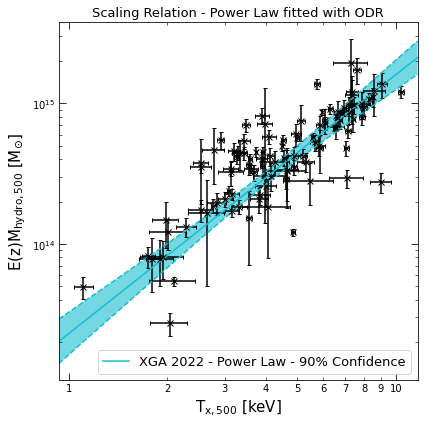

In [33]:
mt_rel.view(figsize=(6, 6), model_colour=xcs3p_colour, save_path='../../outputs/figures/sdssrm-xcs_MT_r500_prelim.pdf')

In [24]:
mr_rel = xcs_srcs.mass_richness()

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/extended.py:669: UserWarning: SDSSXCS-5020 doesn't have a matching hydrostatic mass profile associated
  warn("{s} doesn't have a matching hydrostatic mass profile associated".format(s=gcs.name))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/extended.py:669: UserWarning: SDSSXCS-2346 doesn't have a matching hydrostatic mass profile associated
  warn("{s} doesn't have a matching hydrostatic mass profile associated".format(s=gcs.name))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/extended.py:669: UserWarning: SDSSXCS-586 doesn't have a matching hydrostatic mass profile associated
  warn("{s} doesn't have a matching hydrostatic mass profile associated".format(s=gcs.name))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/extended.py:669: UserWarning: SDSSXCS-28849 doesn't have a matching hydrostatic mass profile associated
  warn("{s} doesn't have a matching hydrostatic mass profile associated".format(s=gcs.name))
/mnt

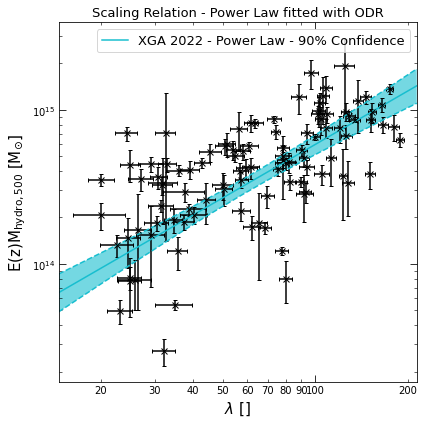

In [34]:
mr_rel.view(figsize=(6, 6), model_colour=xcs3p_colour, 
                 save_path='../../outputs/figures/sdssrm-xcs_MR_r500_prelim.pdf')

In [38]:
ml_rel = xcs_srcs.mass_Lx()

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/extended.py:669: UserWarning: SDSSXCS-5020 doesn't have a matching hydrostatic mass profile associated
  warn("{s} doesn't have a matching hydrostatic mass profile associated".format(s=gcs.name))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/extended.py:669: UserWarning: SDSSXCS-2346 doesn't have a matching hydrostatic mass profile associated
  warn("{s} doesn't have a matching hydrostatic mass profile associated".format(s=gcs.name))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/extended.py:669: UserWarning: SDSSXCS-586 doesn't have a matching hydrostatic mass profile associated
  warn("{s} doesn't have a matching hydrostatic mass profile associated".format(s=gcs.name))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/extended.py:669: UserWarning: SDSSXCS-28849 doesn't have a matching hydrostatic mass profile associated
  warn("{s} doesn't have a matching hydrostatic mass profile associated".format(s=gcs.name))
/mnt

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/base.py:280: UserWarning: There are no XSPEC fits associated with SDSSXCS-21847
  warn(str(err))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/base.py:280: UserWarning: There are no XSPEC fits associated with SDSSXCS-2588
  warn(str(err))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/base.py:280: UserWarning: There are no XSPEC fits associated with SDSSXCS-455
  warn(str(err))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/base.py:280: UserWarning: There are no XSPEC fits associated with SDSSXCS-6307
  warn(str(err))
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/relations/fit.py:71: UserWarning: 43 sources have NaN values and have been excluded
  warn("{} sources have NaN values and have been excluded".format(thrown_away))


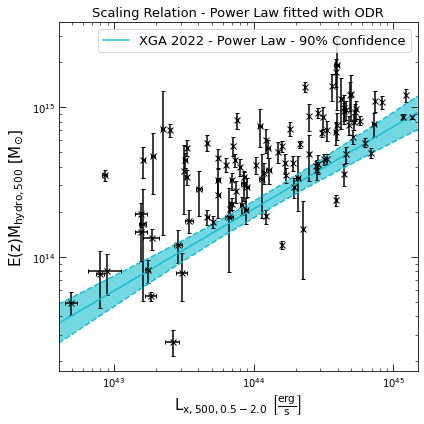

In [39]:
ml_rel.view(figsize=(6, 6), model_colour=xcs3p_colour, 
                 save_path='../../outputs/figures/sdssrm-xcs_ML_r500_prelim.pdf')